In [431]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

# print("Path to dataset files:", path)

# Code
## Imports

In [432]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from datetime import datetime, date
import statsmodels as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
np.random.seed(42)


## Data Ingress

In [433]:
btc = pl.read_csv('btcusd_1-min_data.csv').lazy()
nvidia = pl.read_csv('HistoricalData_1744691062919.csv').lazy()

In [434]:

btc = btc.select(
    pl.col('datetime').str.to_datetime(format="%F %T%:z").cast(pl.Datetime).alias('dates'),
    pl.col('Open').alias('open_btc'),
    pl.col('Volume').alias('volume_btc')
).sort("dates").drop_nulls()

btc_daily = btc.group_by_dynamic(
    "dates", every="1d"
    ).agg(
    pl.col('open_btc').first(),
    pl.col('volume_btc').max()
    ).with_columns(
        pl.col('dates').cast(pl.Date)
    ).with_columns(
        open_btc_trend=pl.col('open_btc').log().diff()
    ).drop_nulls()

btc_daily.collect().head()

dates,open_btc,volume_btc,open_btc_trend
date,f64,f64,f64
2012-01-02,4.84,10.1,0.055216
2012-01-03,5.0,29.319392,0.032523
2012-01-04,5.29,43.312196,0.05638
2012-01-05,5.57,16.0,0.051577
2012-01-06,6.42,20.777444,0.142023


In [435]:
nvidia = nvidia.select(
    pl.col('Date').str.to_date(format="%m/%d/%Y").alias('dates'),
    pl.col('Open').str.replace('$','',literal=True).str.to_decimal().cast(pl.Float64).alias('open_nvidia'),
    pl.col('Volume').alias('volume_nvidia')
).with_columns(
    open_nvidia_trend=pl.col('open_nvidia').log().diff()
).drop_nulls()

nvidia.collect().head()

dates,open_nvidia,volume_nvidia,open_nvidia_trend
date,f64,i64,f64
2025-04-11,108.5,313417300,-0.050413
2025-04-10,109.37,437812400,0.007986
2025-04-09,98.89,612918300,-0.100729
2025-04-08,103.805,476243400,0.048506
2025-04-07,87.46,611041300,-0.171333


In [436]:
fdf = btc_daily.join(nvidia, on='dates', how="inner")

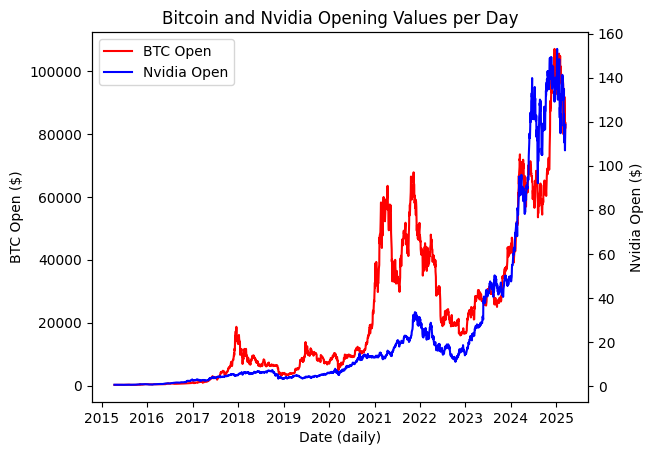

In [437]:

ax = sns.lineplot(
    fdf.collect(),
    x='dates',
    y='open_btc',
    label="BTC Open",
    color='red'
)
ax2 = ax.twinx()
sns.lineplot(
    fdf.collect(),
    x='dates',
    y='open_nvidia',
    ax = ax2,
    label="Nvidia Open",
    color='blue'
)
ax.set_title("Bitcoin and Nvidia Opening Values per Day")
ax.set_ylabel('BTC Open ($)')
ax.set_xlabel('Date (daily)')
ax2.set_ylabel('Nvidia Open ($)')
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Remove old legends
ax.get_legend().remove()
ax2.get_legend().remove()

# Create a single legend
ax.legend(handles, labels, loc='upper left')

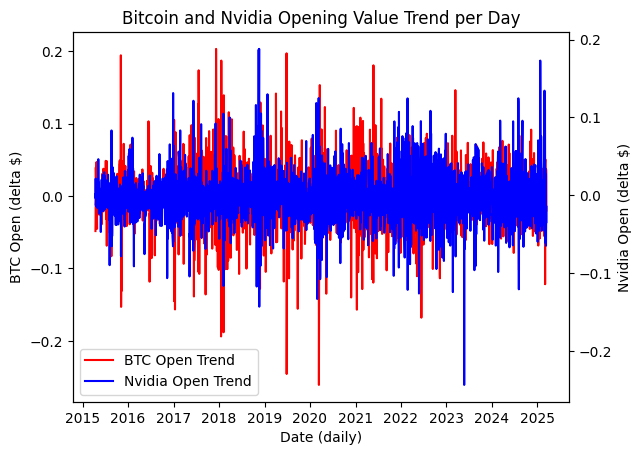

In [438]:

ax = sns.lineplot(
    fdf.collect(),
    x='dates',
    y='open_btc_trend',
    label="BTC Open Trend",
    color='red'
)
ax2 = ax.twinx()
sns.lineplot(
    fdf.collect(),
    x='dates',
    y='open_nvidia_trend',
    ax = ax2,
    label="Nvidia Open Trend",
    color='blue'
)
ax.set_title("Bitcoin and Nvidia Opening Value Trend per Day")
ax.set_ylabel('BTC Open (delta $)')
ax.set_xlabel('Date (daily)')
ax2.set_ylabel('Nvidia Open (delta $)')
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Remove old legends
ax.get_legend().remove()
ax2.get_legend().remove()

# Create a single legend
ax.legend(handles, labels, loc='lower left')

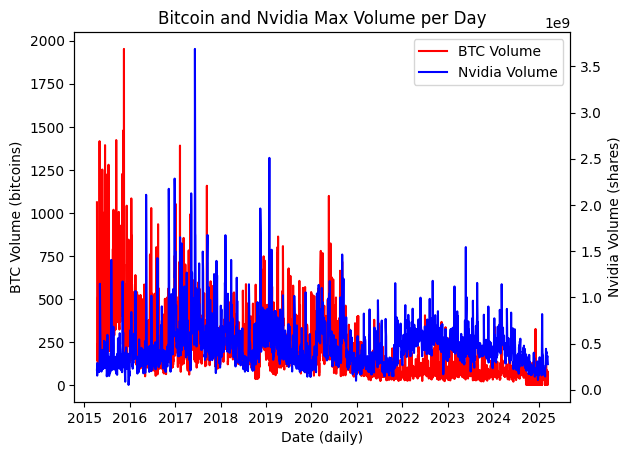

In [439]:

ax = sns.lineplot(
    fdf.collect(),
    x='dates',
    y='volume_btc',
    label="BTC Volume",
    color='red'
)
ax2 = ax.twinx()
sns.lineplot(
    fdf.collect(),
    x='dates',
    y='volume_nvidia',
    ax = ax2,
    label="Nvidia Volume",
    color='blue'
)
ax.set_title("Bitcoin and Nvidia Max Volume per Day")
ax.set_ylabel('BTC Volume (bitcoins)')
ax.set_xlabel('Date (daily)')
ax2.set_ylabel('Nvidia Volume (shares)')
# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Remove old legends
ax.get_legend().remove()
ax2.get_legend().remove()

# Create a single legend
ax.legend(handles, labels, loc='upper right')

## EDA

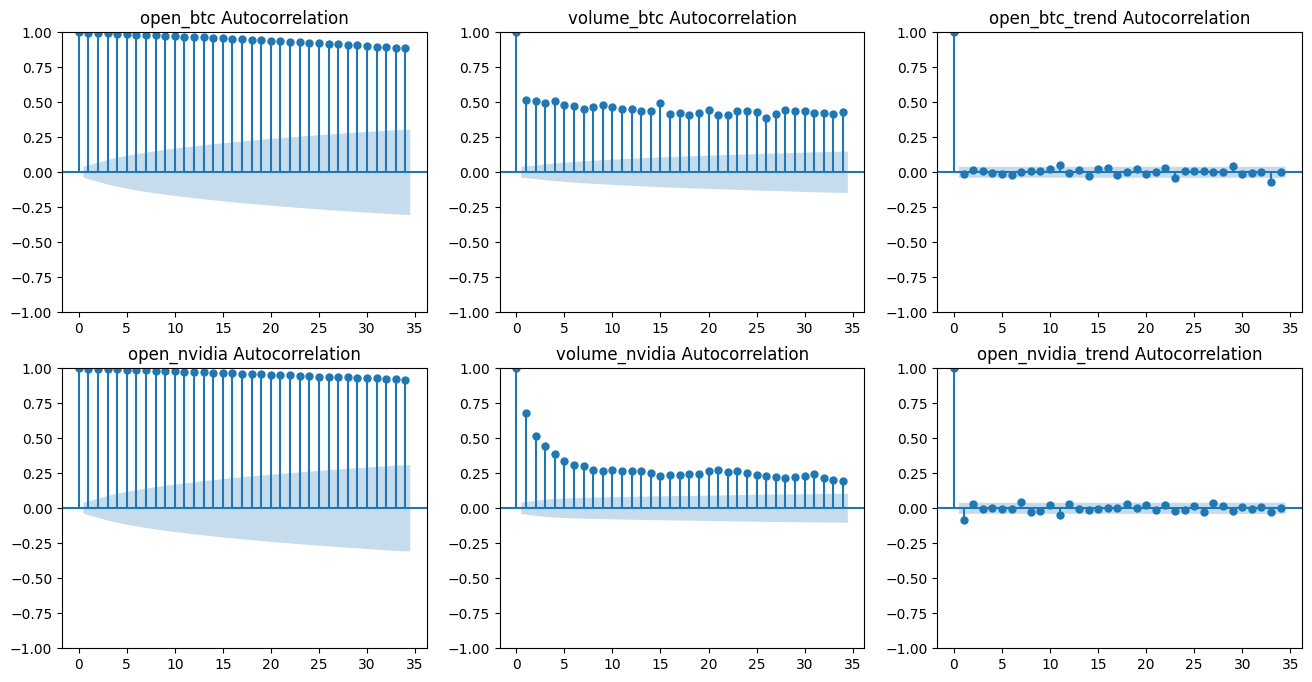

In [440]:
ds = fdf.collect().to_pandas().set_index('dates')

fig, axs = plt.subplots(2,3, figsize=(16,8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    _ = sgt.plot_acf(ds.iloc[:,i], ax=ax)
    ax.set_title(f"{ds.columns[i]} Autocorrelation")



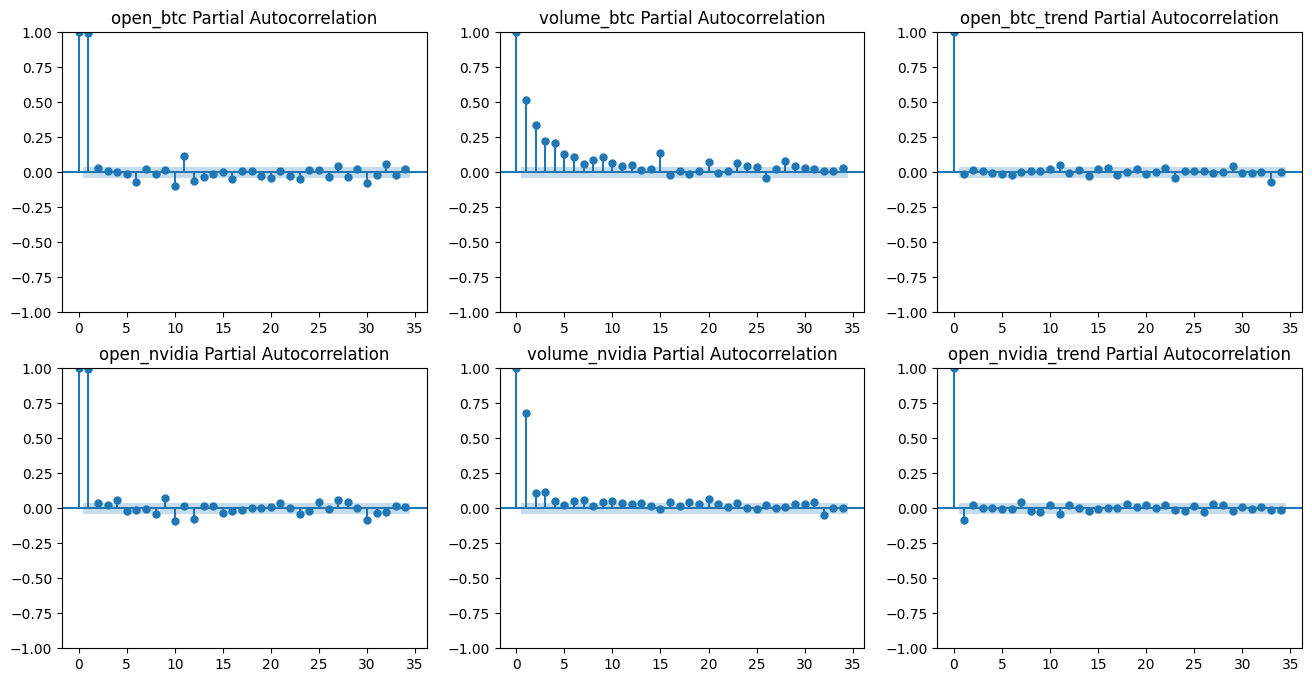

In [441]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    _ = sgt.plot_pacf(ds.iloc[:,i], ax=ax)
    ax.set_title(f"{ds.columns[i]} Partial Autocorrelation")

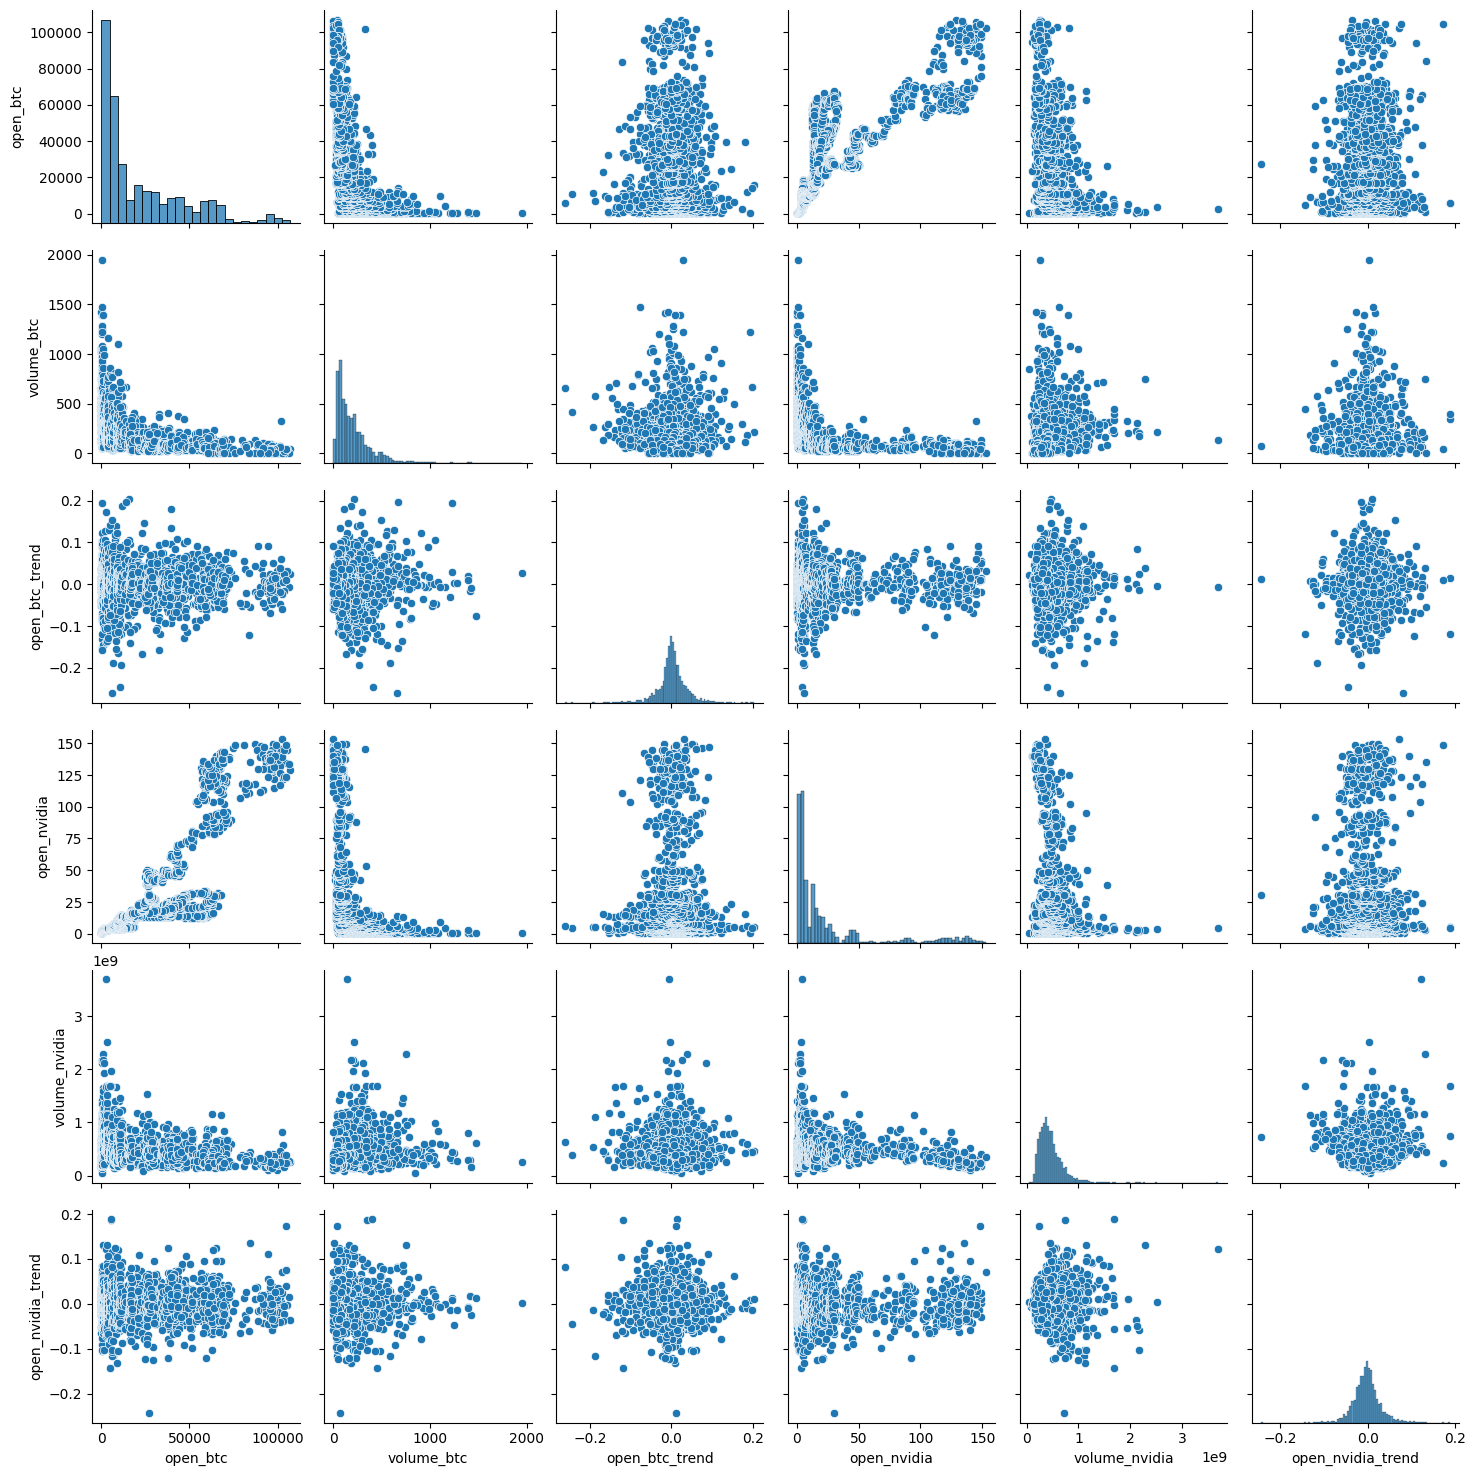

In [442]:
sns.pairplot(ds)

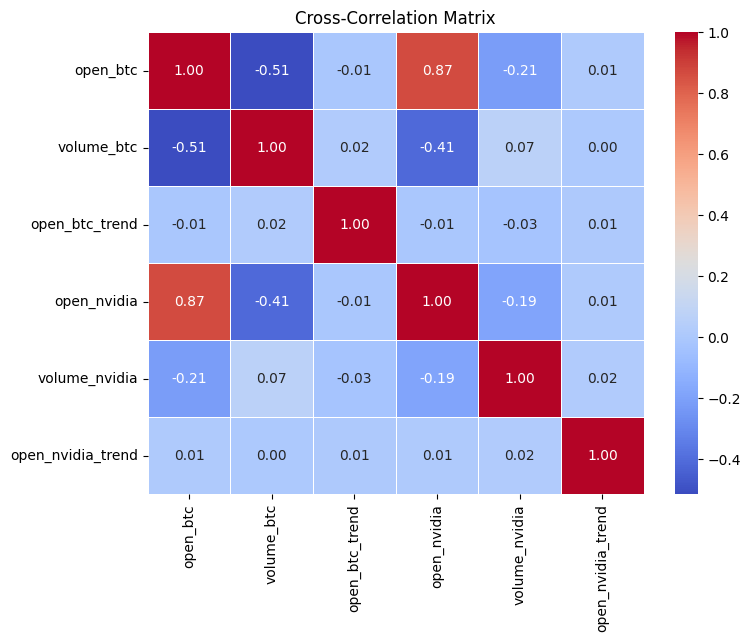

In [443]:
# Calculate the correlation matrix
corr_matrix = ds.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Cross-Correlation Matrix')
plt.show()

In [444]:
test_len = 15
train_set = ds.iloc[:(-1*test_len),:]
test_set = ds.iloc[(-1*test_len):,:] 

## ARIMA

In [450]:
best_params = (0,0,0)
best_rmse = 1e6
results = {'p':[], 'd':[], 'q':[], 'rmse': []}
for q in range(20):
    for d in range(3):
        for p in range(20):
            mod_arima = ARIMA(train_set.open_nvidia, order=(p,d,q))
            res_arima = mod_arima.fit()
            preds = res_arima.get_forecast(steps=test_len)
            rmse = root_mean_squared_error(test_set.open_nvidia, preds.predicted_mean)
            results['p'].append(p)
            results['d'].append(d)
            results['q'].append(q)
            results['rmse'].append(rmse)
            if rmse < best_rmse:
                print(p,d,q,round(rmse,3))
                best_rmse = rmse
                best_params = (p,d,q)

0 0 0 97.001
1 0 0 22.253
6 0 0 22.04
9 0 0 21.8
12 0 0 20.937
14 0 0 20.692
16 0 0 20.464
18 0 0 20.255
19 1 2 19.647
19 1 4 19.321
19 1 5 19.269
17 1 6 19.253
17 1 9 18.498
18 1 9 18.041
16 1 12 17.852
1 0 18 12.777
